# CART: Classification and Regression Trees
<img src = 'https://drive.google.com/uc?id=1CufocdcU3wMg86Sr537-08HUP1C4Reom' width = 80%>

Image source: Louppe, Gilles. Understanding random forests: From theory to practice. Diss. Universite de Liege (Belgium), 2014.

# Introduction and Dataset

## Background

This tutorial provides an example of how to apply classification and regression trees (CARTs), specifically random forest (RF) to model tree species. Here we will approach this challenge in two ways 1) classifying dominant tree species; and 2) regressing tree species proportions.

Estimating dominant tree species is a common task in forestry that is often performed using remote sensing such as in Fancini et al. (2024).

[*Francini, Saverio, et al. "Forest species mapping and area proportion estimation combining Sentinel-2 harmonic predictors and national forest inventory data." International Journal of Applied Earth Observation and Geoinformation 131 (2024): 103935.*](https://doi.org/10.1016/j.jag.2024.103935)

## Tutorial goals

**Goal 1: Develop a random forest (RF) classification model to classify dominant tree species and tree type (coniferous vs. deciduous)**

**Goal 2: Create a new RF model that performs species proportion regression and compare this to the species classification model.**

**Goal 3: Perform feature selection using scikit-learn and remove correlated predictors**

**Goal 4: Experiment with different hyperparameters to limit overfitting**


-----

## Data

This tutorial makes use of light detection and ranging (LiDAR) metrics and multispectral indices that are derived in the Lasso and Ridge Regression Tutorial notebook. Specifically, the `predictors.csv` file generated contains all the predictor variables used in the current tutorial. Please refer to the Lasso and Ridge Regression tutorial for more information about how these metrics/indices were calculated.

# Install and load packages

**Uncomment the cell below to install required packages**

In [1]:
!pip install pandas==2.2.2
!pip install geopandas==1.0.1
!pip install matplotlib==3.10.1
!pip install rioxarray==0.19.0
!pip install spyndex==0.5.0
!pip install pyarrow==19.0.0

  Using cached rioxarray-0.19.0-py3-none-any.whl.metadata (5.5 kB)
Using cached rioxarray-0.19.0-py3-none-any.whl (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.5/727.5 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.6/184.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 kB 18.2 MB/s eta 0:00:00
  Created wheel for spyndex: filename=spyndex-0.5.0-py3-none-any.whl size=767321 sha256=cc59d4a070ae9471f839c57e7da6655976ef68fd37341c3eecd6bb26caa32301
  Stored in directory: /root/.cache/pip/wheels/03/5d/7f/047b431b710b7165f2d2be752885f233acca8d8a7feffaae22
Successfully built spyndex
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 21.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0


In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, cohen_kappa_score, confusion_matrix
import numpy as np
from numpy import sqrt

# Download data

In [3]:
# Download the data if it does not yet exist
if not os.path.exists("data"):
  !gdown 1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
  !unzip prf_data.zip -d data/
  os.remove("prf_data.zip")
else:
  print("Data has already been downloaded.")

os.listdir("data")

Downloading...
From (original): https://drive.google.com/uc?id=1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
From (redirected): https://drive.google.com/uc?id=1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2&confirm=t&uuid=7e627151-13fd-4906-b8c4-e0a521f775bf
To: /content/prf_data.zip
100% 150M/150M [00:01<00:00, 87.3MB/s]
Archive:  prf_data.zip
  inflating: data/als_metrics.tif    
  inflating: data/boundary.gpkg      
  inflating: data/forest_point_cloud.las  
  inflating: data/forest_point_cloud_footprint.gpkg  
  inflating: data/petawawa_s2_2018.tif  
  inflating: data/petawawa_s2_2024.tif  
  inflating: data/plots.gpkg         
  inflating: data/predictors.csv     
  inflating: data/trees.csv          
  inflating: data/water.gpkg         


['forest_point_cloud_footprint.gpkg',
 'predictors.csv',
 'boundary.gpkg',
 'als_metrics.tif',
 'water.gpkg',
 'forest_point_cloud.las',
 'trees.csv',
 'petawawa_s2_2024.tif',
 'petawawa_s2_2018.tif',
 'plots.gpkg']

This block of code calculates dominant tree species based on biomass.

In [4]:
df = pd.read_csv("data/predictors.csv")

# Extract predictor var list
features_ls = df.drop("PlotName", axis=1).columns.tolist()

#Uncomment to see all the variables
# print("Predictor variables:")
# print("\n".join(features_ls))

trees_df = pd.read_csv("data/trees.csv")
df.head(3)

,PlotName,NDVI,NBR,SAVI,MSAVI,DSI,NDWI,GLI,ND705,NDREI,...,d40_42,d42_44,d44_46,d46_48,d4_6,d6_8,d8_10,std_95,vci_1mbin,vci_0.5bin
0,PRF208R,0.880349,0.709994,0.488931,0.606115,0.387605,-0.750999,0.364300,0.547740,0.637373,...,0.0,0.0,0.0,0.0,8.3,0.0,0.0,1.17,0.86,0.88
1,PRF320,0.824918,0.540868,0.356151,0.419385,0.590963,-0.709425,0.278922,0.500269,0.565841,...,0.0,0.0,0.0,0.0,19.1,8.0,2.2,6.65,0.88,0.89
2,PRF016,0.889031,0.678063,0.422625,0.517317,0.407470,-0.762945,0.349233,0.577111,0.658688,...,0.0,0.0,0.0,0.0,2.2,3.4,11.8,5.00,0.87,0.88


# Preprocessing



Let us calculate dominant species in each plot based on biomass for our experiment. First we remove trailing whitespace from species names, then we can view the species composition across entire dataset by count.

In [6]:
trees_df['species'] = trees_df['species'].str.strip()

print(trees_df['species'].value_counts() / len(trees_df) * 100)

species
Balsam fir              14.694202
White pine              14.662431
Red (soft) maple        13.121525
Red pine                10.961080
Jack pine                4.741859
Red oak                  4.654488
White spruce             4.606831
Tamarack                 3.558380
Sugar Maple              3.510723
Trembling Aspen          3.161239
Ironwood                 1.969817
Norway Spruce            1.858618
American beech           1.858618
Black ash                1.787133
White birch              1.739476
Largetooth aspen         1.556791
Yellow birch             0.992851
Basswood                 0.683082
Northern white cedar     0.468626
Eastern hemlock          0.373312
White ash                0.182685
American elm             0.087371
Black cherry             0.087371
Balsam poplar            0.023828
Name: count, dtype: float64


**Question 1 - What can be said about the distribution of species? Describe species evenenss, richness, abundance, and overall diversity in this dataset.**

*Answer here*

<details open>
<summary>Solution</summary>


Distribution of Species:

- Balsam fir, White pine, Red (soft) maple, Red pine are the most common speices sharing roughly the same amount of biomass in the area.

Abundance:

- There is a uneven distribution of abundance among the species.

- Dominant Species: Balsam fir and White pine are by far the most abundant species, with counts of 14.69 and 14.66 respectively. Red (soft) maple (13.12) is also abundant.

- Moderately Abundant Species: Red pine (10.96) and Jack pine (4.74) show moderate abundance.

- Low Abundance Species: A significant number of species have very low abundance, particularly those towards the bottom of the list (e.g., Eastern hemlock, White ash, American elm, Black cherry, Balsam poplar) all with values less than 0.5. Balsam poplar is the least abundant at 0.02.

Evenness:

- The species exhibit low evenness. This is evident from the stark contrast between the high abundance of the top few species and the very low abundance of many others. If the species were evenly distributed, their abundance values would be much closer to each other. The data shows a steep decline in abundance from the most common to the rarest species.

Overall Diversity:

- While the dataset boasts a decent species *richness* (24 species), the low evenness significantly impacts the overall diversity. High dominance by a few species reduces the effective diversity of the ecosystem or sample represented.

In summary, this dataset indicates an ecosystem or sample that is relatively rich in the number of different species, but where a few species are overwhelmingly dominant, leading to low evenness and a lower overall effective diversity than the raw species count might suggest.
</details>

As a routine cleanup when working with any dataset, replace NAs in species with an interpertable value, in this case "Unknown".

In [8]:
trees_df['species'] = trees_df['species'].fillna("Unknown")

Now that we are done with the preprocessing, time to start exploring our experiment below.

# Tree Species Dominance

There are different ways of determining the dominant (i.e., leading) tree species in a given area. The simplest approach perhaps is to count the number of trees of a given species. However, this may not accurately represent dominance since one species may have many small trees that do not account for much volume or area.

Another approach is to calculate dominance based on volume or biomass. This means that a single massive tree may be dominant in a plot even if there are many more smaller trees.

Yet another approach is calculate dominance based on crown area or basal area. Crown area represents how much of the tree is seen from above (i.e., the crown). Basal area represents the area of the tree stem (i.e., trunk) at breast height.

In this tutorial, we will calculate dominance based on total tree volume. This is represented by the `tvol` column in the `trees.csv` dataset.

**Question 2 - Fill in the code below.**

In [ ]:
# Assign a new, unique ID for each tree
trees_df['tree_id'] = trees_df.index + 1

# Lets examine the distribution of species in the dataset
sp_agg = trees_df.groupby('...').agg(
    sp_count=('tree_id', 'count')).sort_values(by='sp_count', ascending=False)

sp_agg['sp_prop'] = sp_agg['sp_count'] / len(trees_df) * 100

sp_agg = round(sp_agg, 2)
print(f"{len(sp_agg)} species found in the dataset.")
print(sp_agg)

In [9]:
# @title Solution
# Assign a new, unique ID for each tree
trees_df['tree_id'] = trees_df.index + 1

# Lets examine the distribution of species in the dataset
sp_agg = trees_df.groupby('species').agg(
    sp_count=('tree_id', 'count')).sort_values(by='sp_count', ascending=False)

sp_agg['sp_prop'] = sp_agg['sp_count'] / len(trees_df) * 100

sp_agg = round(sp_agg, 2)
print(f"{len(sp_agg)} species found in the dataset.")
print(sp_agg)

25 species found in the dataset.
                      sp_count  sp_prop
species                                
Balsam fir                1850    14.69
White pine                1846    14.66
Red (soft) maple          1652    13.12
Red pine                  1380    10.96
Unknown                   1090     8.66
Jack pine                  597     4.74
Red oak                    586     4.65
White spruce               580     4.61
Tamarack                   448     3.56
Sugar Maple                442     3.51
Trembling Aspen            398     3.16
Ironwood                   248     1.97
Norway Spruce              234     1.86
American beech             234     1.86
Black ash                  225     1.79
White birch                219     1.74
Largetooth aspen           196     1.56
Yellow birch               125     0.99
Basswood                    86     0.68
Northern white cedar        59     0.47
Eastern hemlock             47     0.37
White ash                   23     0.18
America

This dataset is quite unbalanced with 20/24 species having less than 5% of the total number of trees. This may make for a difficult classification task. Let's group species into a few similar groups to reduce the number of classes.

In [10]:
trees_df['sp_group'] = None

#This block of code serches unique species names and assigns them to sp_group
for sp in trees_df['species'].unique():

    if 'maple' in sp.lower():
        trees_df.loc[trees_df['species'] == sp, 'sp_group'] = 'Maple'

    elif 'oak' in sp.lower():
        trees_df.loc[trees_df['species'] == sp, 'sp_group'] = 'Oak'

    elif 'spruce' in sp.lower():
        trees_df.loc[trees_df['species'] == sp, 'sp_group'] = 'Spruce'

    elif 'ash' in sp.lower():
        trees_df.loc[trees_df['species'] == sp, 'sp_group'] = 'Ash'

    elif 'birch' in sp.lower():
        trees_df.loc[trees_df['species'] == sp, 'sp_group'] = 'Birch'

    elif 'aspen' in sp.lower():
        trees_df.loc[trees_df['species'] == sp, 'sp_group'] = 'Aspen'

    else:
        trees_df.loc[trees_df['species'] == sp, 'sp_group'] = sp

# Calculates and prints the percentage of each species group in the trees_df
print(round(trees_df['sp_group'].value_counts() / len(trees_df) * 100, 2))

sp_group
Maple                   16.63
Balsam fir              14.69
White pine              14.66
Red pine                10.96
Unknown                  8.66
Spruce                   6.47
Jack pine                4.74
Aspen                    4.72
Oak                      4.65
Tamarack                 3.56
Birch                    2.73
Ash                      1.97
Ironwood                 1.97
American beech           1.86
Basswood                 0.68
Northern white cedar     0.47
Eastern hemlock          0.37
American elm             0.09
Black cherry             0.09
Balsam poplar            0.02
Name: count, dtype: float64


Now we can calculate tree dominance based on volume. We can design a helper function for this to assist us.

**Question 3 - Please fill in the code below**

In [ ]:
def calc_sp_dominance(trees, group_col='sp_group'):

    """
    Calculates the dominant species group within a given DataFrame of trees.

    Args:
        trees (pd.DataFrame): A DataFrame containing tree data, expected to have
                              at least 'tvol' (total volume) and a 'group_col' (species group) column.
        group_col (str, optional): The name of the column containing species group information.
                                   Defaults to 'sp_group'.

    Returns:
        str or None: The name of the dominant species group, or None if the input
                     DataFrame is empty for the current plot.
    """

    # Aggregate the tree data by the specified group_col
    trees_agg = trees.groupby(group_col).agg(sp_tvol=('...', 'sum'),)

    # Calculate the proportional volume for each species group
    trees_agg['sp_vol_prop'] = trees_agg['sp_tvol'] / trees['...'].sum()

    # Sort in descending order by total volume
    trees_agg = trees_agg.sort_values(by='...', ascending=False).reset_index()

    # Get the first row, which holds the dominant species group
    if len(trees_agg) == 0:
        print(f"No trees in plot: {trees['PlotName'].iloc[...]}")
        dom_sp_group = None
    else:
        dom_sp_group = trees_agg[group_col].iloc[0]

    return(dom_sp_group)


In [11]:
# @title Solution
def calc_sp_dominance(trees, group_col='sp_group'):

    # Aggregate the tree data by the specified group_col
    trees_agg = trees.groupby(group_col).agg(sp_tvol=('tvol', 'sum'),)

    # Calculate the proportional volume for each species group
    trees_agg['sp_vol_prop'] = trees_agg['sp_tvol'] / trees['tvol'].sum()

    # Sort in descending order by total volume
    trees_agg = trees_agg.sort_values(by='sp_tvol', ascending=False).reset_index()

    # Get the first row, which holds the dominant species group
    if len(trees_agg) == 0:
        print(f"No trees in plot: {trees['PlotName'].iloc[0]}")
        dom_sp_group = None
    else:
        dom_sp_group = trees_agg[group_col].iloc[0]

    return(dom_sp_group)

Now we can Iterate through each unique plot name in the 'PlotName' column of the DataFrame using our helper function.

**Question 4 - fill in the code below.**

In [ ]:
for plot_nm in df['...']:

    # Filter the 'trees_df' DataFrame to get only the trees belonging to the current plot ('plot_nm').
    trees_i = trees_df[trees_df['PlotName'] == plot_nm]

    # Call the 'calc_sp_dominance' function for the current plot's trees.
    dom_sp_group = ...(trees_i, group_col='sp_group')

    # Assign the determined dominant species group ('dom_sp_group') back to the
    # 'dom_sp_group' column in the main 'df' DataFrame, for the current plot.
    df.loc[df['PlotName'] == plot_nm, 'dom_sp_group'] = dom_sp_group

In [12]:
# @title Solution
for plot_nm in df['PlotName']:

    # Filter the 'trees_df' DataFrame to get only the trees belonging to the current plot ('plot_nm').
    trees_i = trees_df[trees_df['PlotName'] == plot_nm]

    # Call the 'calc_sp_dominance' function for the current plot's trees.
    dom_sp_group = calc_sp_dominance(trees_i, group_col='sp_group')

    # Assign the determined dominant species group ('dom_sp_group') back to the
    # 'dom_sp_group' column in the main 'df' DataFrame, for the current plot.
    df.loc[df['PlotName'] == plot_nm, 'dom_sp_group'] = dom_sp_group

We can now summarize `sp_group` proportions in the dataset

In [13]:
# Calculate the frequency of each dominant species group
sp_group_agg = df['dom_sp_group'].value_counts().reset_index()
# Calculate the percentage of each dominant species group.
sp_group_agg['perc'] = round(sp_group_agg['count'] / len(df) * 100, 2)
sp_group_agg

,dom_sp_group,count,perc
0,White pine,84,35.15
1,Red pine,32,13.39
2,Maple,21,8.79
3,Aspen,21,8.79
4,Oak,17,7.11
5,Jack pine,14,5.86
6,Unknown,13,5.44
7,Spruce,12,5.02
8,Tamarack,8,3.35
9,Balsam fir,5,2.09


Now lets remove plots dominated by unknown species and Remove plots with species dominant in less than 1% of the dataset.

In [14]:
# Filter out rows where 'dom_sp_group' is 'Unknown'.
df = df[df['dom_sp_group'] != 'Unknown']

# Identify "rare" dominant species groups and filter out plots whose dominant species group is in the 'rare_sp' list.
rare_sp = sp_group_agg.loc[sp_group_agg['perc'] < 1, 'dom_sp_group'].tolist()
df = df[~df['dom_sp_group'].isin(rare_sp)]

# Print the percentage distribution of the remaining dominant species groups.
print(df['dom_sp_group'].value_counts()/ len(df) * 100)

dom_sp_group
White pine        38.181818
Red pine          14.545455
Aspen              9.545455
Maple              9.545455
Oak                7.727273
Jack pine          6.363636
Spruce             5.454545
Tamarack           3.636364
Balsam fir         2.272727
American beech     1.363636
Ash                1.363636
Name: count, dtype: float64


Assign nummieric IDs to each dominant species. We can do this by creating a dictionary mapping species names to their IDs.

**Question 5  - fill in the code below.**

In [ ]:
# Convert the 'dom_sp_group' column to a categorical data type.
df['dom_sp_group_id'] = df['dom_sp_group'].astype('category').cat.codes

# Create a dictionary to map the numerical 'dom_sp_group_id' back to their original 'dom_sp_group' names.
dom_sp_dict = (df[['...', '...']]
               .drop_duplicates()
               .sort_values(by='dom_sp_group_id')
               .set_index('dom_sp_group_id', drop=True)
               .to_dict()['dom_sp_group'])

dom_sp_dict

In [16]:
# @title Solution
# Convert the 'dom_sp_group' column to a categorical data type.
df['dom_sp_group_id'] = df['dom_sp_group'].astype('category').cat.codes

# Create a dictionary to map the numerical 'dom_sp_group_id' back to their original 'dom_sp_group' names.
dom_sp_dict = (df[['dom_sp_group', 'dom_sp_group_id']]
               .drop_duplicates()
               .sort_values(by='dom_sp_group_id')
               .set_index('dom_sp_group_id', drop=True)
               .to_dict()['dom_sp_group'])

dom_sp_dict

{0: 'American beech',
 1: 'Ash',
 2: 'Aspen',
 3: 'Balsam fir',
 4: 'Jack pine',
 5: 'Maple',
 6: 'Oak',
 7: 'Red pine',
 8: 'Spruce',
 9: 'Tamarack',
 10: 'White pine'}

Now that we have aquired all the needed peices to preform our experiment, lets begin!

# Goal 1 - Classify Dominant Species

Now lets train a random forest model to predict dominant species based on predictors. First, let split the dataset into training and test sets using stratified sampling to preserve the class distribution, ensuring that all species groups are proportionally represented. Then visualize the distribution of classes in both sets to verify balance. A Random Forest model is trained on the selected feature columns `features_ls` and used to predict the species group in the test set. The model's performance is evaluated using accuracy and Cohen's kappa, with the latter accounting for chance agreement. Finally, a confusion matrix heatmap is plotted to show how well the model distinguishes between different species groups, helping to identify where misclassifications occur.

In the code chunk below, we break the random forest modelling into three general steps:

1) divide the dataset into training and testing using a 70% - 30% split.

2) Train the random forest variable using the defined explanatory variables (i.e., features) and response variable.

3) Evaluate the random forest classifier using a confusion matrix and metrics (overall accuracy and kappa).


Accuracy: 0.59
Kappa: 0.46


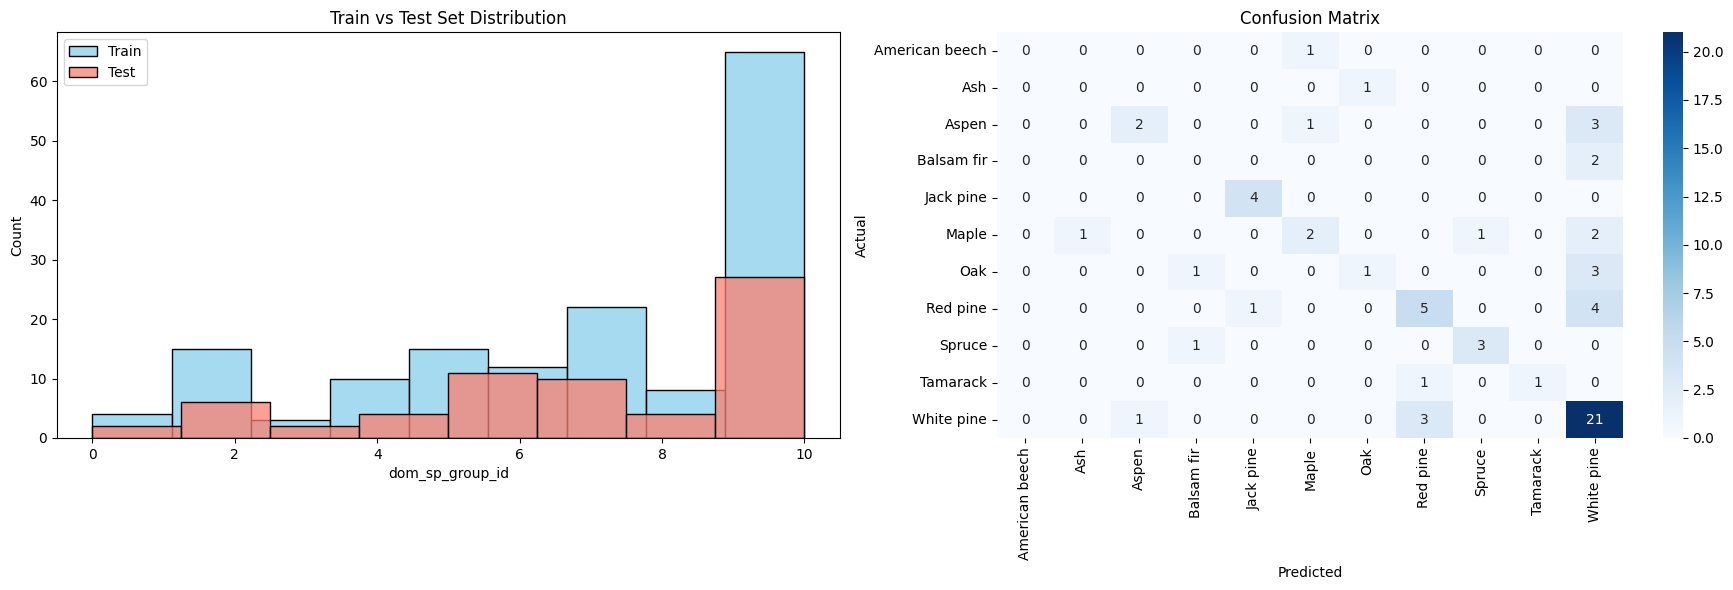

In [17]:
# 1) Use simple train/test split using stratified sampling for now, apply cross-validation later
train_df, test_df =  train_test_split(df[['dom_sp_group_id'] + features_ls],
                 stratify=df['dom_sp_group_id'],
                 test_size=0.3,
                 random_state=25)


# 2) Train the random forest variable using the defined explanatory variables (i.e., features) and response variable.
rf = RandomForestClassifier(n_estimators=100, random_state=25)
rf.fit(train_df[features_ls], train_df['dom_sp_group_id'])

# Apply the model to the test set
test_df['pred_dom_sp_group_id'] = rf.predict(test_df[features_ls])

# 3) Calculate accuracy and kappa
accuracy = accuracy_score(test_df['dom_sp_group_id'], test_df['pred_dom_sp_group_id'])
kappa = cohen_kappa_score(test_df['dom_sp_group_id'], test_df['pred_dom_sp_group_id'])

print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa: {kappa:.2f}")

# Compare the distribution of dominant species in the training and test sets and print confusion matrix side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(train_df['dom_sp_group_id'], ax=axes[0], color='skyblue', label='Train', kde=False)
sns.histplot(test_df['dom_sp_group_id'], ax=axes[0], color='salmon', label='Test', kde=False)
axes[0].set_title('Train vs Test Set Distribution')
axes[0].legend()

# Print confusion matrix
conf_matrix = confusion_matrix(test_df['dom_sp_group_id'], test_df['pred_dom_sp_group_id'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=dom_sp_dict.values(),
            yticklabels=dom_sp_dict.values(),
            ax=axes[1])
axes[1].set_title('Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


**Question 1 - After examining the cell output, what can be said about our classification model?**

*Answer here*

<details open>
<summary>Solution</summary>
As can be seen in the confusion matrix and classification metrics above, the model performance is not great. It is possible this could be improved somewhat by tuning hyperparameters, curating the datasets, etc.
In this case, we will further simplify the problem to improve our results. Now instead of classifying tree species group, we will simply perform a  classification to determine whether a forest is coniferous (evergreen) vs. deciduous (leafy) dominated, or is mixed.
</details>

Given that our model is not accurate, we will try to reprocess the data to be more useful to decision tree models.

# Classify Dominant Tree Type (Coniferous/Deciduous)

For optimal performance, decision trees rely on binary decisions. This means each question within the tree should have only two possible answers, like "yes/no" or "greater than/less than," requiring your input to be structured accordingly.

Group the species in the dataset based on coniferous/deciduous. To determine whether a plot is coniferous/deciduous dominated, we will use a volume threshold of 75%. In other words, if >75% of the plot tree volume is coniferous, it is considered to be a coniferous stand, with the same logic applied to deciduous. If a plot's volume is <75% dominated, it is considered mixed. You can adjust this threshold to see how it affects model performance.

Let's simplify the problem and just classify whether a plot is broadleaf or deciduous. Create a dict indicating whether a species is coniferous ('c') or deciduous ('d')

> **_Note - Why do we do this:_** Before we can label a plot (which contains many trees), we need to know what type each species is. This dictionary maps each species name to 'c' (coniferous) or 'd' (deciduous).

**Question 2 - Please fill in the code below.**

In [ ]:
dom_sp_type_dict = {
    'Balsam fir': 'c',
    'White pine': 'c',
    'Red (soft) maple': 'd',
    'Red pine': 'c',
    'Jack pine': 'c',
    'Red oak': 'd',
    'White spruce': 'c',
    'Tamarack': 'c',
    'Sugar Maple': 'd',
    'Trembling Aspen': 'd',
    'Ironwood': 'd',
    'Norway Spruce': 'c',
    'American beech': 'd',
    'Black ash': 'd',
    'White birch': 'd',
    'Largetooth aspen': 'd',
    'Yellow birch': 'd',
    'Basswood': 'd',
    'Northern white cedar': 'c',
    'Eastern hemlock': 'c',
    'White ash': 'd',
    'American elm': 'd',
    'Black cherry': 'd',
    'Balsam poplar': 'd'
}

# Convert to df
sp_type_df = (pd.DataFrame.from_dict(dom_sp_type_dict, columns=['dom_sp_type'], orient='index')
              .reset_index()
              .rename(columns={'index': 'species'}))

# Join with trees
trees_df = trees_df.merge(..., on='species', how='left')

trees_df

In [19]:
# @title Solution
dom_sp_type_dict = {
    'Balsam fir': 'c',
    'White pine': 'c',
    'Red (soft) maple': 'd',
    'Red pine': 'c',
    'Jack pine': 'c',
    'Red oak': 'd',
    'White spruce': 'c',
    'Tamarack': 'c',
    'Sugar Maple': 'd',
    'Trembling Aspen': 'd',
    'Ironwood': 'd',
    'Norway Spruce': 'c',
    'American beech': 'd',
    'Black ash': 'd',
    'White birch': 'd',
    'Largetooth aspen': 'd',
    'Yellow birch': 'd',
    'Basswood': 'd',
    'Northern white cedar': 'c',
    'Eastern hemlock': 'c',
    'White ash': 'd',
    'American elm': 'd',
    'Black cherry': 'd',
    'Balsam poplar': 'd'
}

# Convert to df
sp_type_df = (pd.DataFrame.from_dict(dom_sp_type_dict, columns=['dom_sp_type'], orient='index')
              .reset_index()
              .rename(columns={'index': 'species'}))

# Join with trees
trees_df = trees_df.merge(sp_type_df, on='species', how='left')

trees_df

,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size,tree_id,sp_group,dom_sp_type
0,PRF001,24.0,White pine,P,D,10.1,NaN,1.0,11.552521,0.128190,N,0.000000,0.708735,393.396400,Poles,1,White pine,c
1,PRF001,46.0,White pine,P,D,9.9,NaN,2.0,11.422529,0.123163,N,0.000000,0.673254,375.305379,Poles,2,White pine,c
2,PRF001,20.0,Red pine,N,L,67.5,D,NaN,33.900000,5.725566,Y,77.327438,79.482658,39691.639950,Large,3,Red pine,c
3,PRF001,50.0,Red pine,N,L,57.9,D,NaN,32.528851,4.212773,Y,56.444281,58.117292,28251.255888,Large,4,Red pine,c
4,PRF001,10.0,White pine,N,L,55.9,D,NaN,33.000000,3.926761,Y,48.008649,49.833743,24501.838779,Large,5,White pine,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12585,PRF334,NaN,Sugar Maple,N,L,3.7,NaN,NaN,8.893640,0.215043,N,0.000000,0.858564,851.191939,Under,12586,Maple,d
12586,PRF334,NaN,Sugar Maple,N,L,3.3,NaN,NaN,8.500000,0.171060,N,0.000000,0.653868,659.084439,Under,12587,Maple,d
12587,PRF334,NaN,Sugar Maple,N,L,3.2,NaN,NaN,8.395967,0.160850,N,0.000000,0.607493,615.333049,Under,12588,Maple,d
12588,PRF334,NaN,Sugar Maple,N,L,3.0,NaN,NaN,7.400000,0.141372,N,0.000000,0.469656,521.064025,Under,12589,Maple,d


We will classify a stand as Conifer (c) or Deciduous (d) dominated if the volume of a given type is greater than a specified threshold percentage

> **_Note - Why do we do this:_** We define a dominance threshold. If ≥75% of a plot’s tree volume is coniferous, it’s a coniferous plot. If ≤25% is coniferous, it’s deciduous. Anything in between is considered mixed. This simplification reduces a complex problem (many species and combinations) into a binary or 3-class classification problem, which is easier for a model to handle.

In [20]:
CONIF_PERC_THRESH = 75

This code below calculates the percentage of conifer volume for each plot and classifies plots as coniferous ('c'), deciduous ('d'), or mixed ('m') based on a conifer percentage threshold. First, it defines a function calc_conifer_perc() to compute the percentage of total tree volume made up of conifers (identified by dom_sp_type == 'c'). For each plot in the dataset, it calculates this percentage using tree-level data (trees_df) and stores the result in a new column conif_perc in the plot-level dataframe (df).


> **_Note - Why do we do this:_** We aggregate tree volumes within each plot to calculate the percentage of volume made up by coniferous trees. This derived feature (conif_perc) is used to classify the plot’s dominant tree type.

**Question 3 - Please fill in the code below**


In [ ]:
def calc_conifer_perc(trees):

    conif_df = trees[trees['...'] == '...'].reset_index(drop=True)

    total_vol = trees['...'].sum()

    conif_vol = conif_df['...'].sum()

    conif_perc = round(conif_vol / total_vol * 100, 2)

    return(conif_perc)

for plot_nm in df['...']:

    trees_i = trees_df[trees_df['PlotName'] == plot_nm]

    conif_perc = calc_conifer_perc(trees_i)

    df.loc[df['PlotName'] == plot_nm, 'conif_perc'] = conif_perc

In [24]:
# @title Solution
def calc_conifer_perc(trees):

    conif_df = trees[trees['dom_sp_type'] == 'c'].reset_index(drop=True)

    total_vol = trees['tvol'].sum()

    conif_vol = conif_df['tvol'].sum()

    conif_perc = round(conif_vol / total_vol * 100, 2)

    return(conif_perc)

for plot_nm in df['PlotName']:

    trees_i = trees_df[trees_df['PlotName'] == plot_nm]

    conif_perc = calc_conifer_perc(trees_i)

    df.loc[df['PlotName'] == plot_nm, 'conif_perc'] = conif_perc

Below is the classify_plot_type() function. Each plot is labeled as coniferous if its percentage is above the threshold, deciduous if below the complement of the threshold (i.e. ≤25%), or mixed otherwise. These classifications are converted into an ordered categorical type to support proper sorting or modeling.

> **_Note - Why do we do this:_** We label each plot based on its dominant tree type. Categorizing this is essential for visualizing data distribution and defining the target variable (plot_type) for training the classifier.

In [25]:
# Classify plots as coniferous (c), deciduous (d), or mixed (m) based on the conifer percentage
def classify_plot_type(conif_perc, conif_perc_thresh):

    if (conif_perc >= conif_perc_thresh):
        return 'c'

    elif conif_perc <= abs(conif_perc_thresh - 100):
        return 'd'
    else:
        return 'm'

Finally, the code visualizes the distribution of these plot types and prints the percentage of each class across the dataset.

> **_Note - Why do we do this:_** Before modeling, we need to understand class balance (e.g., are most plots coniferous?). This affects model performance and determine need for class weighting or resampling

dom_type
c    55.0
m    28.0
d    17.0
Name: count, dtype: float64 0


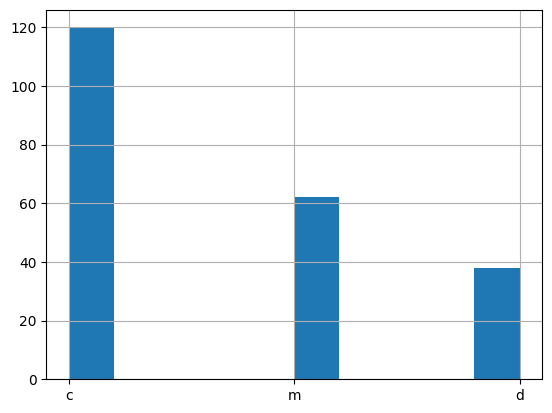

In [26]:
df['dom_type'] = df['conif_perc'].apply(lambda x: classify_plot_type(x, CONIF_PERC_THRESH))

# Convert to ordered catopegory
cat_type = CategoricalDtype(categories=['c', 'd', 'm'], ordered=True)

df['dom_type'] = df['dom_type'].astype(cat_type)

# View distribution of dominant types
df['dom_type'].hist()

print(round(df['dom_type'].value_counts() / len(df) * 100), 0)

Now that we have the data from above, we can train a new random forest model to predict broadleaf vs coniferous.

**Question 3 - Fill in the code below.**


In [ ]:
train_df, test_df =  ...(df[['dom_type'] + features_ls],
                 stratify=df['dom_type'],
                 test_size=0.3,
                 random_state=25)

rf = ...(n_estimators=100, random_state=25)

rf....(train_df[features_ls], train_df['dom_type'])

# Apply the model to the test set
test_df['pred_dom_type'] = rf....(test_df[features_ls])

# Calculate accuracy and kappa
accuracy = accuracy_score(test_df['dom_type'], test_df['pred_dom_type'])
kappa = cohen_kappa_score(test_df['dom_type'], test_df['pred_dom_type'])

print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa: {kappa:.2f}")

# Print confusion matrix

conf_matrix = ...(test_df['dom_type'], test_df['pred_dom_type'])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Coniferous', 'Deciduous', 'Mixed'],
            yticklabels=['Coniferous', 'Deciduous', 'Mixed'])

print(test_df['dom_type'].value_counts())


Accuracy: 0.76
Kappa: 0.59
dom_type
c    36
m    19
d    11
Name: count, dtype: int64


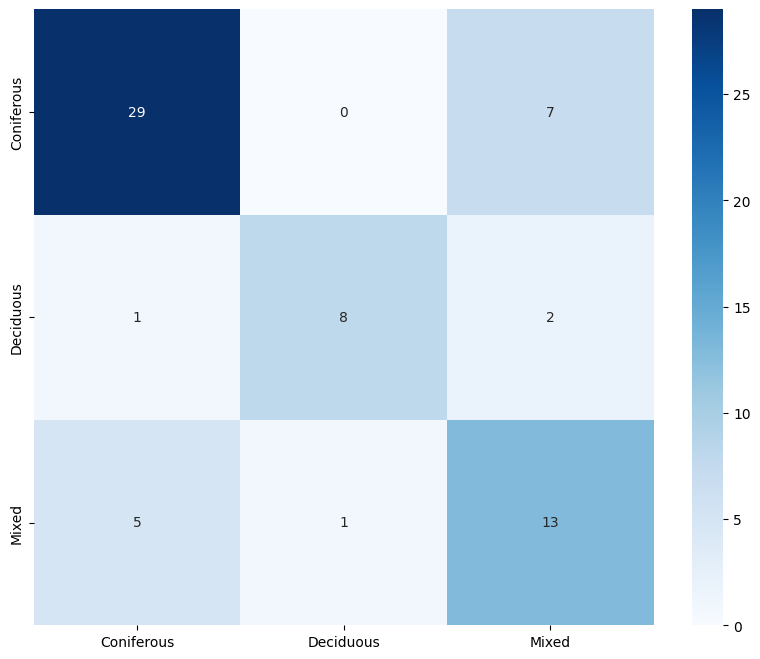

In [27]:
# @title Solution
train_df, test_df =  train_test_split(df[['dom_type'] + features_ls],
                 stratify=df['dom_type'],
                 test_size=0.3,
                 random_state=25)

rf = RandomForestClassifier(n_estimators=100, random_state=25)

rf.fit(train_df[features_ls], train_df['dom_type'])

# Apply the model to the test set
test_df['pred_dom_type'] = rf.predict(test_df[features_ls])

# Calculate accuracy and kappa
accuracy = accuracy_score(test_df['dom_type'], test_df['pred_dom_type'])
kappa = cohen_kappa_score(test_df['dom_type'], test_df['pred_dom_type'])

print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa: {kappa:.2f}")

# Print confusion matrix

conf_matrix = confusion_matrix(test_df['dom_type'], test_df['pred_dom_type'])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Coniferous', 'Deciduous', 'Mixed'],
            yticklabels=['Coniferous', 'Deciduous', 'Mixed'])

print(test_df['dom_type'].value_counts())

Much better accuracy!

**Question 4 - Investigate qualities of plots that were misclassified. Why do you think these plots were misclassified?**

*Answer here*

<details open>
<summary>Solution</summary>
General Reasons for Misclassification:

- Feature Limitations: The features extracted from the plots (e.g., spectral bands, texture, height) may not perfectly capture the distinct characteristics that differentiate these forest types, especially in transitional or heterogeneous areas.

- Training Data Bias/Quality: If the training data for the model was not perfectly representative of all variations within each class, or if there were labeling errors in the training data, it could lead to misclassifications.

- Boundary Ambiguity: The definitions of "Coniferous," "Deciduous," and "Mixed" can sometimes have fuzzy boundaries in nature. A plot might genuinely exhibit characteristics that fall between categories.

- Environmental Factors: Variations in light conditions, atmospheric effects (if using remote sensing), or ground conditions can influence the data and lead to misinterpretations.

- Model Complexity/Hyperparameters: The model itself (e.g., its algorithm, hyperparameters) might not be optimally tuned to handle the nuances of these classifications.

- Spatial Resolution: If using imagery, the resolution might not be fine enough to distinguish individual trees or small patches of different species within a plot.
</details>

# Goal 2 - Regress Conifer Percentage

Classifying a plot as coniferous, deciduous or mixed is simple and effective, however it not capture the nuance of species composition. An interesting approach to machine learning is considering how different modelling objectives can be approached as either classification, or regression problems.

Below we will apply a random forest regressor to estimate coniferous proportion to derive more specific information about species composition in the dataset.

First lets view the conifer percentage to get an idea of the data.

Text(0, 0.5, 'Frequency')

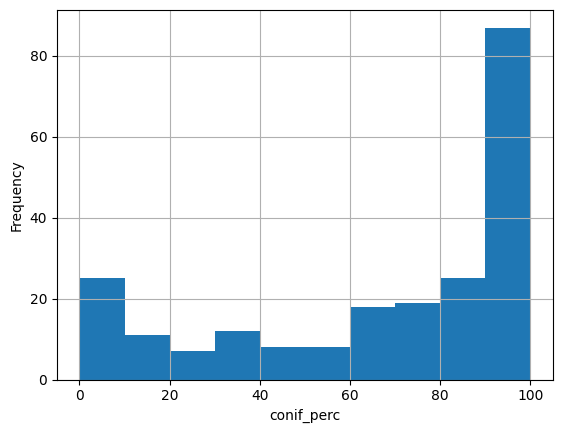

In [28]:
df['conif_perc'].hist()
plt.xlabel('conif_perc')
plt.ylabel('Frequency')

Train a random forest model to predict balsam fir percentage

**Question 1 - fill in the code below.**

In [ ]:
train_df, test_df =  ...(df[['conif_perc'] + features_ls],
                                        test_size=0.3,
                                        random_state=25)

rf = ...(n_estimators=100, random_state=25)

rf....(train_df[features_ls], train_df['conif_perc'])

# Apply the model to the test set
test_df['pred_conif_perc'] = rf....(test_df[features_ls])

# Calculate regression metrics

rmse = sqrt(mean_squared_error(test_df['...'], test_df['pred_conif_perc']))
r2 = r2_score(test_df['...'], test_df['pred_conif_perc'])

print(f"RMSE: {rmse:.5f}")
print(f"R²: {r2:.5f}")

# Plot the predicted vs actual values
plt.figure(figsize=(10, 8))
sns.scatterplot(x=test_df['conif_perc'], y=test_df['pred_conif_perc'])
plt.xlabel(f'Actual conif_perc Percentage')
plt.ylabel(f'Predicted conif_perc Percentage')
plt.grid(True)
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='1:1 Line')

plt.xlim(0, 100)
plt.ylim(0, 100)

RMSE: 15.25786
R²: 0.77384


(0.0, 100.0)

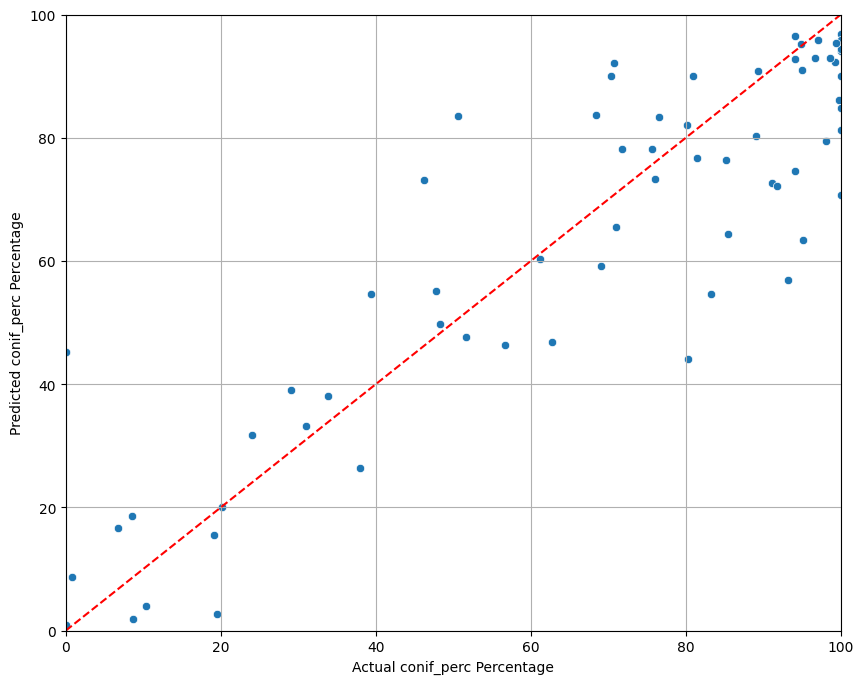

In [29]:
# @title Solution
train_df, test_df =  train_test_split(df[['conif_perc'] + features_ls],
                                        test_size=0.3,
                                        random_state=25)

rf = RandomForestRegressor(n_estimators=100, random_state=25)

rf.fit(train_df[features_ls], train_df['conif_perc'])

# Apply the model to the test set
test_df['pred_conif_perc'] = rf.predict(test_df[features_ls])

# Calculate regression metrics

rmse = sqrt(mean_squared_error(test_df['conif_perc'], test_df['pred_conif_perc']))
r2 = r2_score(test_df['conif_perc'], test_df['pred_conif_perc'])

print(f"RMSE: {rmse:.5f}")
print(f"R²: {r2:.5f}")

# Plot the predicted vs actual values
plt.figure(figsize=(10, 8))
sns.scatterplot(x=test_df['conif_perc'], y=test_df['pred_conif_perc'])
plt.xlabel(f'Actual conif_perc Percentage')
plt.ylabel(f'Predicted conif_perc Percentage')
plt.grid(True)
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='1:1 Line')

plt.xlim(0, 100)
plt.ylim(0, 100)

Interpret the RMSE, what are the units? What does this represent?

Discuss the difference in performance between classifying dominant tree type (coniferous, deciduous, mixed) versus regressing coniferous prorpotion.

*Answer here*

<details open>
<summary>Solution</summary>
1. Classification (Dominant Tree Type):

 - Goal: To assign each plot to one of a predefined set of discrete categories (e.g., Coniferous, Deciduous, Mixed).

- Strengths (as seen in the confusion matrix):

    - Simplicity and Interpretability for Discrete Classes: It provides a clear, single label for a plot, which can be useful for broad management decisions (e.g., "This entire stand is coniferous").

    - Good for Clear-Cut Distinctions: When there are strong, unambiguous differences between categories (e.g., pure coniferous vs. pure deciduous), classification models can perform very well (as evidenced by 0 misclassifications between Coniferous and Deciduous in the previous matrix).

    - Handles Non-Linear Relationships: Classification models can capture complex decision boundaries between classes.

- Weaknesses (implied by the data):

    - Loss of Nuance (Especially for "Mixed"): The "Mixed" category in classification lumps together plots with a wide range of coniferous proportions (e.g., 20% coniferous, 80% deciduous vs. 70% coniferous, 30% deciduous). This loses valuable information about the degree of mixing. The misclassifications in the "Mixed" category in the previous image highlight this; a truly "mixed" plot might be labeled coniferous if it's heavily coniferous-dominated, or deciduous if it's deciduous-dominated, even if it still contains both.

     - Arbitrary Thresholds: Classification requires defining thresholds to separate categories (e.g., "mixed" means between X% and Y% coniferous). These thresholds can be somewhat arbitrary and lead to misclassifications for plots near the boundaries.

     - Hard Boundaries: A classification model forces a hard decision, even when a plot might be borderline between two types.

2. Regression (Coniferous Proportion):

- Goal: To predict a continuous numerical value (the exact percentage of coniferous trees).

- Strengths (as seen in the scatter plot):

    - Captures Granular Information: Regression provides a more detailed and quantitative understanding of the forest composition. Instead of just "mixed," it tells you how mixed (e.g., 45% coniferous). This is crucial for precise ecological studies, biomass estimation, or timber volume calculations.

    - No Arbitrary Thresholds: The model directly predicts the proportion, avoiding the need for predefined categories.

    - Better for Gradual Transitions: It naturally handles the continuum of forest compositions from pure deciduous to pure coniferous, including all degrees of mixing. The red dashed line in the scatter plot (representing perfect prediction) shows that the goal is to align actual with predicted values across the entire range.

- Weaknesses (as seen in the scatter plot):

    - More Challenging for High Accuracy: Predicting an exact percentage can be more difficult than assigning a broad category. The scatter of points around the dashed line indicates that there is variability in the predictions, especially in the middle ranges (e.g., 20-80% actual coniferous).

    - Sensitivity to Outliers: As mentioned, RMSE is sensitive to larger errors. A few highly inaccurate predictions can significantly impact the RMSE.

    - Interpretation for "Dominant Type": While it gives you the proportion, if you need a single dominant type label, you'd still have to apply thresholds to the regression output (e.g., >70% coniferous = coniferous, <30% = deciduous, else mixed). This brings back some of the issues of classification.
</detais>

Our model shows strong performance, but we've identified areas for enhancement. Our future goals include implementing strategies that boost performance while meticulously avoiding overfitting and data skew.

# Goal 3- Add feature selection using a method from SKlearn:

https://scikit-learn.org/stable/modules/feature_selection.html


Feature selection is a technique used to pick the most relevant features (or variables) from your dataset. This helps your machine learning model focus on what's truly important.

One key reason to use feature selection is to address highly correlated features. When two or more features in your dataset are strongly correlated, they essentially carry very similar information. If your model is trained with all of these redundant features, it can lead to overfitting.

Reasons:

- Redundancy: The model tries to learn from information that's already largely represented by another feature, making it unnecessarily complex.

- Noise Absorption: An overly complex model, especially with redundant features, might start to "memorize" the specific quirks and noise in your training data rather than the underlying patterns.

- Reduced Generalization: When a model overfits, it performs really well on the data it was trained on but struggles significantly when it encounters new, unseen data. This means its real-world performance will be poor.

By removing these highly correlated features, you're essentially simplifying the model. This makes it less prone to overfitting and helps it generalize better to new data. Ultimately, this often leads to a better performing model that's more robust and reliable.

First we will check Correlation Between Predictors. These often impact scoring.

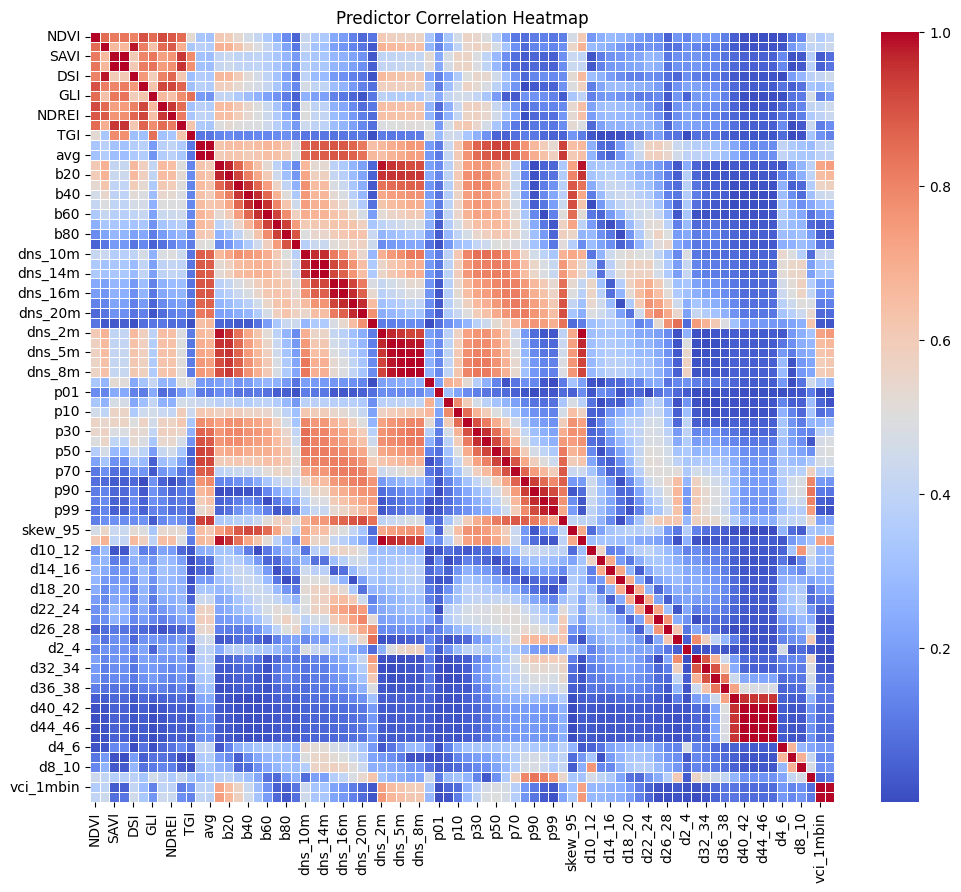

In [30]:
# Calculate correlation matrix
corr_matrix = df[features_ls].corr().abs()

# Visualize correlation matrix (optional)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=0.5)
plt.title("Predictor Correlation Heatmap")
plt.show()

This gives us an idea that there does exists a bunch of highly correlated features. There exists methods in sklearn which can help reduce or remove them.



`from sklearn.feature_selection import RFECV`

This imports **Recursive Feature Elimination with Cross-Validation (RFECV)** from `scikit-learn`.

- Selects the most important features by:
  1. Fitting a model using all features.
  2. Ranking feature importance.
  3. Removing the least important feature(s) recursively.
  4. Using **cross-validation** to find the optimal number of features.

- Helps reduce overfitting.
- Speeds up training by removing irrelevant features.
- Improves model interpretability.


`from sklearn.preprocessing import StandardScaler`

This imports the StandardScaler from scikit-learn.


- Standardizes the features by:

    1. Removing the mean (centering).
    2. Scaling to unit variance.
    3. After scaling, each feature will have:
    4. Mean = 0
    5. Standard deviation = 1

- Required or beneficial for many ML algorithms like:
    1. Logistic Regression
    2. SVMs
    3. K-Nearest Neighbors (KNN)
    4. PCA
    5. Ensures that features are on the same scale.

In [31]:
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

Before training the regression model, start by making a copy of the original DataFrame to avoid modifying the raw data. Next, define the feature matrix X using the selected feature list (features_ls) and set the target variable y as the column representing conifer percentage (conif_perc). Since many machine learning models perform better with standardized input, apply feature scaling using StandardScaler to transform the features so they have a mean of 0 and standard deviation of 1. Finally, convert the scaled array back into a DataFrame with the same column names and index as the original.

**Question 1 - Please fill in the code below.**

In [ ]:
# Make a copy of the original dataframe
df_fs = df.copy()

# Define features (X) and target (y)
X = df_fs[...]
y = df_fs['...']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_ls, index=X.index)

In [32]:
# @title Solution
# Make a copy of the original dataframe
df_fs = df.copy()

# Define features (X) and target (y)
X = df_fs[features_ls]
y = df_fs['conif_perc']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_ls, index=X.index)

After preprocessing the data, split the scaled dataset into training and testing sets to evaluate model performance on unseen data. In this case, 30% of the data is reserved for testing, and a fixed random seed ensures reproducibility. Then, initialize a RandomForestRegressor model with 100 estimators and a fixed random state for consistent results. To perform feature selection, use RFECV (Recursive Feature Elimination with Cross-Validation), which repeatedly removes the least important features while evaluating model performance using 5-fold cross-validation. It uses negative mean squared error as the scoring metric. Finally, fit the RFECV object to the training data to identify the optimal subset of features.

**Question 2 - Please fill in the code below.**


> **_Note:_** This code might take some time to finish running. It should take no more than 5 minutes.

In [ ]:
# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y,
                                                    test_size=0.3,
                                                    random_state=25)

# Initialize the Random Forest Regressor
estimator = ...(n_estimators=100, random_state=25)

# Initialize RFECV
rfecv = ...(estimator=estimator, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit RFECV to find the optimal number of features
rfecv.fit(X_train, y_train)

In [33]:
# @title Solution
# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y,
                                                    test_size=0.3,
                                                    random_state=25)

# Initialize the Random Forest Regressor
estimator = RandomForestRegressor(n_estimators=100, random_state=25)

# Initialize RFECV
rfecv = RFECV(estimator=estimator, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit RFECV to find the optimal number of features
rfecv.fit(X_train, y_train)

RFECV(cv=5, estimator=RandomForestRegressor(random_state=25), n_jobs=-1,
      scoring='neg_mean_squared_error')

Running the code below will show some stats about the Random forest model.

In [34]:
print(f"Optimal number of features : {rfecv.n_features_}")
print("Selected features (True means selected):")
print(rfecv.support_)

Optimal number of features : 23
Selected features (True means selected):
[ True  True  True  True False  True  True False  True  True  True False
 False False False False  True False  True  True  True  True False False
 False False False False  True False False False False False False False
 False False False False False  True False False False  True False False
 False False False False False  True  True  True False  True False False
 False False False False False False False False False False False False
  True False False  True False False]


Once RFECV has identified the most important features, extract their names by using the support_ mask from the fitted RFECV object and apply it to the training DataFrame’s column names. This gives a list of features that were selected as optimal for the model. To better understand how the number of features affects model performance, visualize the cross-validation results. We created a line plot showing the number of features selected on the x-axis and the corresponding negative mean squared error on the y-axis. This plot helps illustrate how model performance changes as more or fewer features are included in training.


Selected features: ['NDVI', 'NBR', 'SAVI', 'MSAVI', 'NDWI', 'GLI', 'NDREI', 'IRECI', 'TGI', 'b40', 'b60', 'b70', 'b80', 'b90', 'dns_20m', 'p40', 'p80', 'd12_14', 'd14_16', 'd16_18', 'd20_22', 'd4_6', 'std_95']


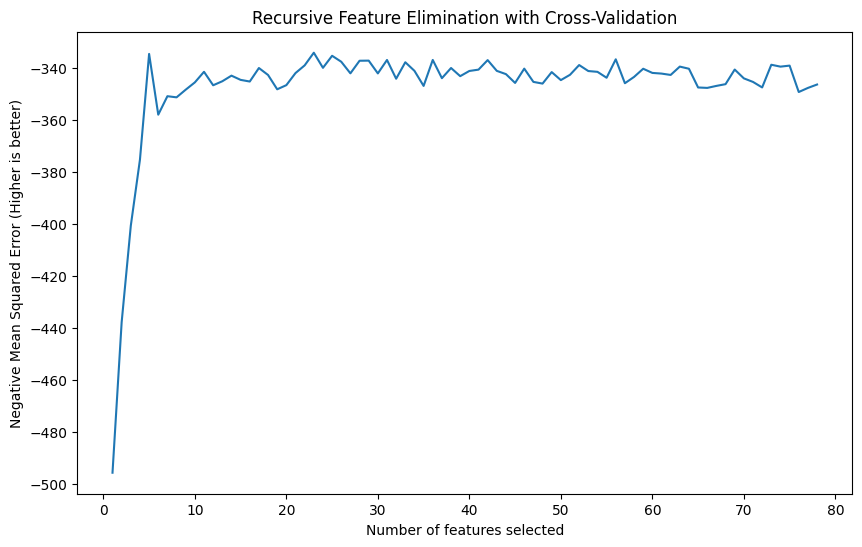

In [35]:
# Get the names of the selected features
selected_features = X_train.columns[rfecv.support_].tolist()
print(f"\nSelected features: {selected_features}")

# Visualize the RFE scores
plt.figure(figsize=(10, 6))
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel('Number of features selected')
plt.ylabel('Negative Mean Squared Error (Higher is better)')

# Corrected line: Use .cv_results_['mean_test_score'] from the estimator within RFECV
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

As the graph indicates, performance plateaus around 23 features. Selecting additional features would lead to overfitting and is unnecessary.

After selecting the optimal subset of features using RFECV, retrain the RandomForestRegressor using only those selected features. Fit the model on the training data and then make predictions on the test set using the same selected features. To evaluate how well the model performs, calculate regression metrics including Root Mean Squared Error (RMSE) and the coefficient of determination (R²). These metrics give insight into prediction accuracy and how well the model explains the variance in the target variable. Finally, create a scatter plot comparing the actual versus predicted values for the conifer percentage. The plot includes a red dashed line representing a perfect 1:1 prediction. The closer the points are to this line, the better the model's predictive performance.

**Question 3 - fill in the code below.**

In [ ]:
# Train the Random Forest Regressor with only the selected features
rf_reg_selected = ...(n_estimators=100, random_state=25)
rf_reg_selected.fit(X_train[selected_features], y_train)

# Make predictions on the test set using only the selected features
y_pred_selected = rf_reg_selected....(X_test[selected_features])

# Calculate and print regression metrics for the model with selected features
rmse_selected = sqrt(mean_squared_error(y_test, y_pred_selected))
r2_selected = r2_score(y_test, y_pred_selected)

print(f"\nRMSE with selected features: {rmse_selected:.5f}")
print(f"R² with selected features: {r2_selected:.5f}")

In [36]:
# @title Solution
# Train the Random Forest Regressor with only the selected features
rf_reg_selected = RandomForestRegressor(n_estimators=100, random_state=25)
rf_reg_selected.fit(X_train[selected_features], y_train)

# Make predictions on the test set using only the selected features
y_pred_selected = rf_reg_selected.predict(X_test[selected_features])

# Calculate and print regression metrics for the model with selected features
rmse_selected = sqrt(mean_squared_error(y_test, y_pred_selected))
r2_selected = r2_score(y_test, y_pred_selected)

print(f"\nRMSE with selected features: {rmse_selected:.5f}")
print(f"R² with selected features: {r2_selected:.5f}")


RMSE with selected features: 15.20054
R² with selected features: 0.77553


This code below plots the predicted vs actual values for the model with selected features.

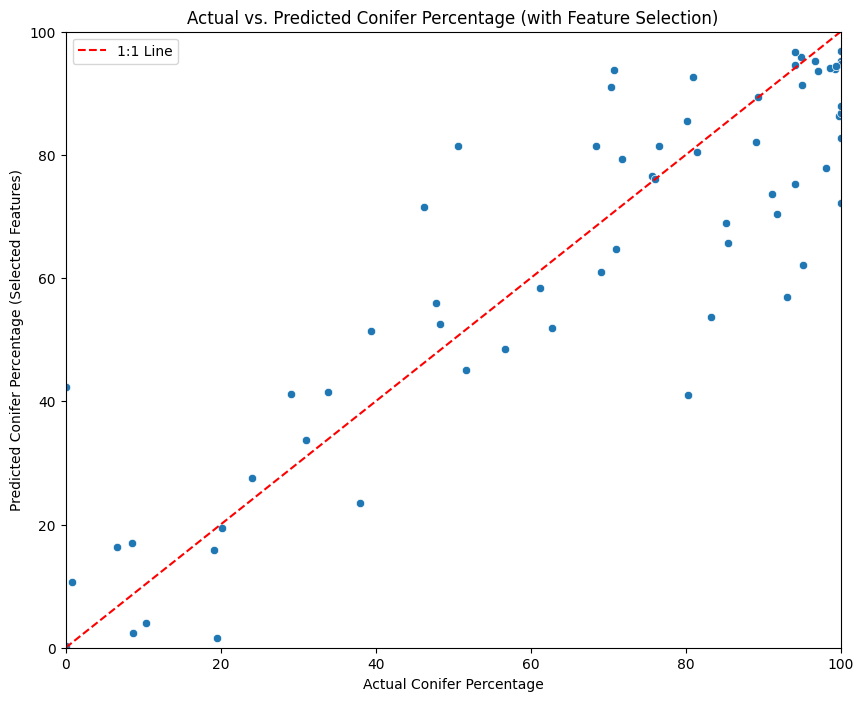

In [37]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred_selected)
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='1:1 Line')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel('Actual Conifer Percentage')
plt.ylabel('Predicted Conifer Percentage (Selected Features)')
plt.title('Actual vs. Predicted Conifer Percentage (with Feature Selection)')
plt.legend()
plt.show()

In summary, while we've made progress, we haven't yet seen the significant performance improvement we hoped for. This often points to the need for further model optimization.

A critical area to address is the hyperparameters of our model. These are settings that are configured before the training process begins, and their values can dramatically impact how well the model learns and performs. Manually testing an endless number of combinations is impractical.

Fortunately, Python offers powerful tools to automatically search through and tune these hyperparameters. In the next section, we will explore the steps to leverage these automated methods, aiming to unlock a better-performing model.

# Goal 4 - Experiment with different hyperparameters to limit overfitting

Now, let's move on to experimenting with different hyperparameters to try and achieve a better-performing model. While this isn't a guaranteed solution for massive leaps in performance, it's often a relatively easy and highly recommended step that can yield noticeable improvements.

Hyperparameters control the learning process and structure of our model (e.g., the number of trees in a Random Forest or the maximum depth of a decision tree). By systematically searching for the optimal combination of these settings, we can fine-tune our model to better fit the data and generalize more effectively. It's a powerful way to squeeze out that extra bit of performance, and the setup is usually quite straightforward in Python.

Looking at the code below:

**What it does:**
- Uses `selected_features` if it was created earlier (e.g., through feature selection).
- Otherwise, defaults to all features in `features_ls`.

**Why it's important:**
- Helps avoid overfitting by using only relevant features.
- Speeds up model training.
- Ensures your model doesn't learn from irrelevant data.



In [38]:
features_to_use = selected_features if 'selected_features' in locals() else features_ls
print(f"Starting hyperparameter tuning on {len(features_to_use)} features.")

Starting hyperparameter tuning on 23 features.


We will use feature selection and hyperparamter tunning together rather than seperate, as it would always be best to do both of these things.

`from sklearn.model_selection import GridSearchCV`

This imports `GridSearchCV`, a hyperparameter tuning tool from scikit-learn.

GridSearchCV searches for the best hyperparameter combination by:

 - Exhaustively trying every single combination of hyperparameters from a pre-defined grid of values.

- Using cross-validation to evaluate model performance for each combination.

- Guarantees finding the best combination within the defined grid, but can be computationally expensive when the parameter space is large.

- Best suited for smaller parameter spaces or when you need to be certain you've found the optimal combination within your defined search range.

In [39]:
from sklearn.model_selection import GridSearchCV

> **_Note:_** This code might take some time to finish running. It should take no more than 5 minutes.

In [41]:
param_grid = {
    # Number of trees in the forest. Increasing this generally improves performance
    # up to a certain point, after which returns diminish. Common values range from
    # 100 to 200, balancing performance with computational cost.
    'n_estimators': [100, 150, 200],

    # The maximum depth of the tree. Limiting depth helps control overfitting.
    # 'None' means nodes are expanded until all leaves are pure or contain
    # less than min_samples_split samples.
    'max_depth': [10, 20, 30, None],

    # The minimum number of samples required to split an internal node.
    # Higher values prevent a model from learning relations which are highly specific
    # to the particular training samples, thus reducing overfitting.
    'min_samples_split': [2, 5, 10],

    # The minimum number of samples required to be at a leaf node.
    # Similar to min_samples_split, higher values lead to more generalized models.
    'min_samples_leaf': [1, 2, 5],

    # The number of features to consider when looking for the best split.
    # 'sqrt' (square root of total features) is a common and often effective choice
    # for Random Forests, as it introduces randomness and reduces correlation
    # between trees.
    'max_features': ['sqrt'],

    # Whether bootstrap samples are used when building trees.
    # 'True' (default) means that each tree in the forest is built from a
    # bootstrap sample of the training data, which is fundamental to
    # the bagging ensemble method of Random Forests.
    'bootstrap': [True]
}

**Question 1 - fill in the code below to do hyperparameters tuning with GridSearch**

In [ ]:
rf = RandomForestRegressor(random_state=25, oob_score=True)

grid_search = GridSearchCV(
    estimator=...,
    param_grid=...,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train[features_to_use], y_train)

print(f"\nBest hyperparameters found by Faster RandomizedSearchCV: {grid_search.best_params_}")
print(f"Best cross-validation score (negative MSE): {grid_search.best_score_:.2f}")

In [43]:
# @title Solution
rf = RandomForestRegressor(random_state=25, oob_score=True)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train[features_to_use], y_train)

print(f"\nBest hyperparameters found by Faster RandomizedSearchCV: {grid_search.best_params_}")
print(f"Best cross-validation score (negative MSE): {grid_search.best_score_:.2f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best hyperparameters found by Faster RandomizedSearchCV: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score (negative MSE): -17.54


Looking at the code below:


**What it does:**
- Evaluates the best model's performance on unseen test data.
- Reports RMSE and R² score.

**Why it's important:**
- Confirms whether your tuned model generalizes well.
- RMSE tells you how far off predictions are on average.
- R² indicates how much variance in the target is explained.

In [44]:
# Get the best model
best_grid_model = grid_search.best_estimator_

# Make predictions on the test set with the best model
y_pred_grid = best_grid_model.predict(X_test[features_to_use])

# Evaluate the best model
rmse_grid = sqrt(mean_squared_error(y_test, y_pred_grid))
r2_grid = r2_score(y_test, y_pred_grid)

print(f"\nRMSE of the best model on test set: {rmse_grid:.5f}")
print(f"R² of the best model on test set: {r2_grid:.5f}")


RMSE of the best model on test set: 15.00286
R² of the best model on test set: 0.78133


The plot below displays the predicted values against the actual values for our model, which was trained using the selected features. We can observe that the prediction line closely follows the general trend of the data points and exhibits a good fit, indicating that the model's performance in capturing the underlying relationship is satisfactory.

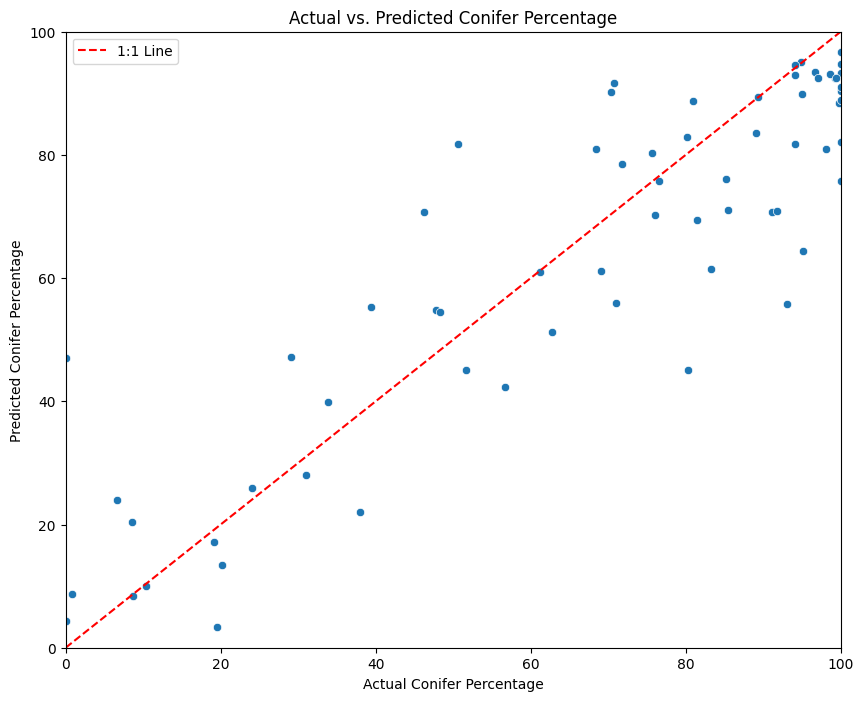

In [45]:
# Plotting results for the best tuned model
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred_grid)
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='1:1 Line')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel('Actual Conifer Percentage')
plt.ylabel('Predicted Conifer Percentage')
plt.title('Actual vs. Predicted Conifer Percentage')
plt.legend()
plt.show()

Now that we have a scoring metric for GridSearchCV, let's explore RandomizedSearchCV, another powerful search method that efficiently samples random hyperparameter combinations from specified distributions, often finding good solutions faster than GridSearchCV for large search spaces.

Now looking at the code below:

`from sklearn.model_selection import RandomizedSearchCV`

This imports `RandomizedSearchCV`, a hyperparameter tuning tool from `scikit-learn`.

`RandomizedSearchCV` searches for the best hyperparameter combination by:
- Sampling a fixed number of **random combinations** from a specified distribution or list of parameters.
- Using **cross-validation** to evaluate model performance for each sampled combination.

- Faster than `GridSearchCV` when the parameter space is large.
- Allows use of **continuous distributions** (e.g., `uniform`) and **discrete distributions** (e.g., `randint`).

`from scipy.stats import randint, uniform`
This imports random distribution generators from scipy.stats:

- randint
    - Generates random integers from a specified range (e.g., randint(10, 100) → 10 to 99).

    - Used for hyperparameters that require integer values like n_estimators, max_depth, etc.

- uniform
    - Generates continuous float values from a uniform distribution over an interval.

    - Useful for hyperparameters like learning_rate or regularization strength.

In [46]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

Looking at the code below:

**What it does:**
- Prepares a randomized search over the defined parameter space.

**Why it's important:**
- Tunes multiple hyperparameters in parallel.
- Uses cross-validation to evaluate each configuration reliably.
- Reduces training time compared to `GridSearchCV`.


In [48]:
# Define the parameter distributions to sample from for a faster Randomized Search
param_grid_random = {
    # Number of trees in the forest. Using randint for RandomSearchCV allows the
    # search to sample a wide, continuous range, providing more flexibility than
    # discrete values. Here, it samples uniformly from 100 up to (but not including) 200.
    'n_estimators': randint(100, 200),

    # The maximum depth of the tree. Similar to n_estimators, using randint for depth
    # enables the random search to explore a broader spectrum of tree complexities,
    # from shallow (10) to relatively deep (up to, but not including, 30).
    'max_depth': randint(10, 30),

    # The minimum number of samples required to split an internal node.
    # Random sampling within this range helps in finding an optimal balance
    # between model complexity and preventing overfitting on specific training examples.
    'min_samples_split': randint(2, 10),

    # The minimum number of samples required to be at a leaf node.
    # Randomly sampling this parameter helps in exploring various levels of
    # model generalization, from highly specific (1 sample) to more generalized (up to 5 samples).
    'min_samples_leaf': randint(1, 5),

    # The number of features to consider when looking for the best split.
    # 'sqrt' (square root of total features) is a common and often effective choice
    # for Random Forests, as it introduces randomness and reduces correlation
    # between trees. This is kept as a fixed categorical choice, as typically
    # a few well-known strategies (like 'sqrt', 'log2', or float fractions) are sufficient.
    'max_features': ['sqrt'],

    # Defines whether bootstrap samples are used when building trees.
    # 'True' (default) means that each tree in the forest is built from a
    # bootstrap sample of the training data, which is fundamental to
    # the bagging ensemble method of Random Forests. This is usually kept
    # fixed as 'True' for a standard Random Forest.
    'bootstrap': [True]
}

Looking at the code below:

**What it does:**
- Trains multiple versions of the model using different parameter combinations.
- Selects the best-performing model based on cross-validation score.

**Why it's important:**
- Finds the best model configuration to improve accuracy and generalization.
- Automates tuning, reducing guesswork.

**Question 2 - fill in the code below.**

> **_Note:_** This code might take some time to finish running. It should take no more than 5 minutes.

In [ ]:
# Initialize RandomForestRegressor
# Use OOB score for internal validation and regularization benefit
rf_fast = ...(random_state=25, oob_score=True, bootstrap=True)

# Improve scoring metric to RMSE instead of MSE (same optimization direction but more interpretable)
random_search_fast = ...(
    estimator=...,
    param_distributions=...,
    n_iter=60,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=25,
    n_jobs=-1,
    verbose=1
)

# Fit RandomizedSearchCV to the training data using the selected features
random_search_fast....(X_train[features_to_use], y_train)

print(f"\nBest hyperparameters found by Faster RandomizedSearchCV: {random_search_fast.best_params_}")
print(f"Best cross-validation score (negative MSE): {random_search_fast.best_score_:.2f}")

In [49]:
# @title Solution
# Initialize RandomForestRegressor
# Use OOB score for internal validation and regularization benefit
rf_fast = RandomForestRegressor(random_state=25, oob_score=True, bootstrap=True)

# Improve scoring metric to RMSE instead of MSE (same optimization direction but more interpretable)
random_search = RandomizedSearchCV(
    estimator=rf_fast,
    param_distributions=param_grid_random,
    n_iter=60,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=25,
    n_jobs=-1,
    verbose=1
)

# Fit RandomizedSearchCV to the training data using the selected features
random_search.fit(X_train[features_to_use], y_train)

print(f"\nBest hyperparameters found by Faster RandomizedSearchCV: {random_search.best_params_}")
print(f"Best cross-validation score (negative MSE): {random_search.best_score_:.2f}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best hyperparameters found by Faster RandomizedSearchCV: {'bootstrap': True, 'max_depth': 26, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 125}
Best cross-validation score (negative MSE): -17.61


In [50]:
# Get the best model
best_random_model = random_search.best_estimator_

# Make predictions on the test set with the best model
y_pred_random = random_search.predict(X_test[features_to_use])

# Evaluate the best model
rmse_random = sqrt(mean_squared_error(y_test, y_pred_random))
r2_random = r2_score(y_test, y_pred_random)

print(f"\nRMSE of the best model on test set: {rmse_random:.5f}")
print(f"R² of the best model on test set: {r2_random:.5f}")


RMSE of the best model on test set: 15.25042
R² of the best model on test set: 0.77406


The plot below displays the predicted values against the actual values for our model, which was trained using the selected features. We can observe that the prediction line closely follows the general trend of the data points and exhibits a good fit, indicating that the model's performance in capturing the underlying relationship is satisfactory.

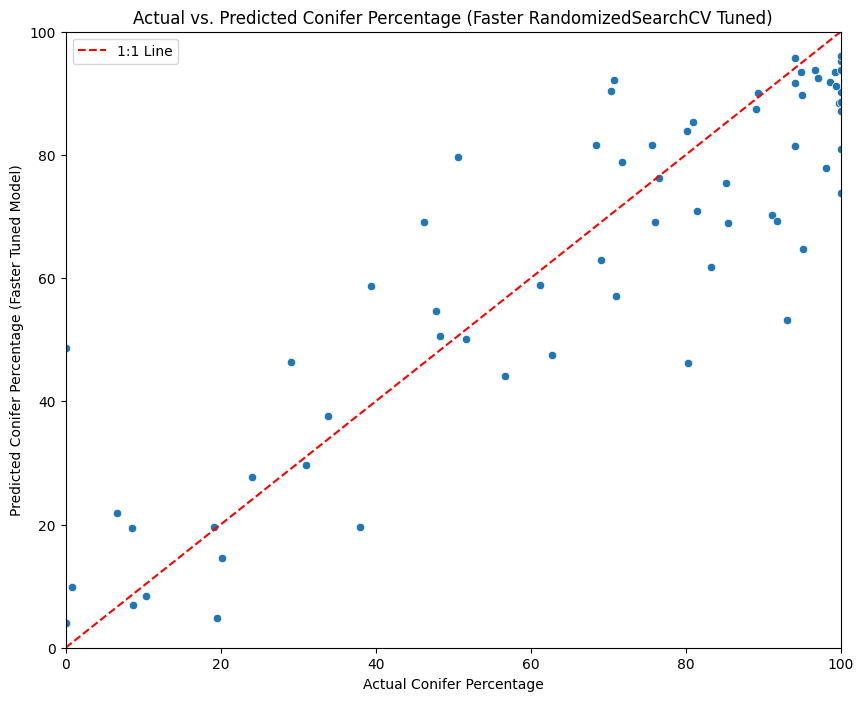

In [51]:
# Plotting results for the best tuned model
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred_random)
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='1:1 Line')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel('Actual Conifer Percentage')
plt.ylabel('Predicted Conifer Percentage (Faster Tuned Model)')
plt.title('Actual vs. Predicted Conifer Percentage (Faster RandomizedSearchCV Tuned)')
plt.legend()
plt.show()

To synthesize our findings and illustrate the results of our modeling approaches, the table below offers a side-by-side comparison of key performance metrics (RMSE and R²) for each experiment conducted in this tutorial. Graphs are omitted due to minimal variation between them.

In [52]:
results = {
    'Metric': ['RMSE', 'R²'],
    'Baseline Model': [rmse, r2],
    'Feature Selection': [rmse_selected, r2_selected],
    'Randomized Search': [rmse_random, r2_random],
    'Grid Search': [rmse_grid, r2_grid]
}

results_df = pd.DataFrame(results)

print("Experiment Results Comparison:")
print(results_df.round(5).to_string(index=False))

Experiment Results Comparison:
Metric  Baseline Model  Feature Selection  Randomized Search  Grid Search
  RMSE        15.25786           15.20054           15.25042     15.00286
    R²         0.77384            0.77553            0.77406      0.78133


**Question 3 - What are some conclusions which you can draw from this result?**

*Answer here*

<details open>
<summary>Solution</summary>
While Grid Search yielded the best results, the overall performance improvement across all methods is relatively modest. The change in RMSE is only about 0.25 (from ~15.25 to ~15.00) and R² increased by less than 1% (from ~0.773 to ~0.781). This suggests that while hyperparameter tuning helped refine the model, there might be inherent limitations in the dataset, the chosen model type, or further pre-processing steps (like more advanced feature engineering) that could lead to more substantial gains.
details
</details>

This experiment reinforced that achieving accurate models with decision trees and random forests is contingent on correct tuning. We found that hyperparameter and feature selection offered slight performance enhancements in our specific case, but recognizing their potential for substantial impact, they remain common and recommended practices for model optimization across various situations.